### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from lib.similarity import CentroidSimilarity

from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.experiment_utils import get_feature_extractor, extract_features, preprocessing_model, identity_model, classifiers_hyper_tune
from utils.experiment_utils import scan_experiment
from utils.experiment_utils import get_images_from_supervised_set
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from utils.visualization import bar_plot_scores
from transformers import ViTImageProcessor

%load_ext autoreload
%autoreload 2

In [2]:
models_dir = "c:/transformer_models/"
if os.path.isdir(models_dir) is not True:
    os.mkdir(models_dir)

In [3]:
datasets_dir = "c:/datasets/"
if os.path.isdir(datasets_dir) is not True:
    os.mkdir(datasets_dir)

### Model Definition

In [4]:
model_id = "google/vit-base-patch16-224-in21k"
vit_image_processor = ViTImageProcessor.from_pretrained(model_id, cache_dir=models_dir)
print(f"do_resize = {vit_image_processor.do_resize}")
print(f"do_rescale = {vit_image_processor.do_rescale}")
print(f"do_normalize = {vit_image_processor.do_normalize}")
print(f"size = {vit_image_processor.size}")


do_resize = True
do_rescale = True
do_normalize = True
size = {'height': 224, 'width': 224}


In [6]:
def vit_image_preprocessing(ds, label_set, max_samples_per_class):
    images = []
    labels = []
    samples_per_class = {label : 0 for label in label_set}
    # iterate over the data set, collect only samples belonging to the label set
    for image, label in tfds.as_numpy(ds):
         if label in label_set and samples_per_class[label] < max_samples_per_class:
             a = vit_image_processor(image)
             images.append(a['pixel_values'][0])
             labels.append(label)
             samples_per_class[label] += 1
    # stack the images and labels into nd arrays
    images = tf.stack(images)
    labels = tf.stack(labels)
    return images, labels


In [7]:
def vit_feature_extractor(vit_model, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = vit_model.vit(inputs)
    outputs = x.last_hidden_state[:,0,:]
    return tf.keras.Model(inputs, outputs)

In [8]:
import tensorflow as tf
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k', cache_dir=models_dir)
base_model.trainable = False
base_model.summary()

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  86389248  
                                                                 
Total params: 86,389,248
Trainable params: 0
Non-trainable params: 86,389,248
_________________________________________________________________


## Experiment 1 - CUB 2001

### Load dataset

In [11]:
ds_name = 'caltech_birds2011'
ds, ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(ds_info)

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    full_name='caltech_birds2011/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='c:/datasets/caltech_birds2011\\0.1.1',
    file_format=tfrecord,
    download_size=1.11 GiB,
    dataset_size=1.11 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': I

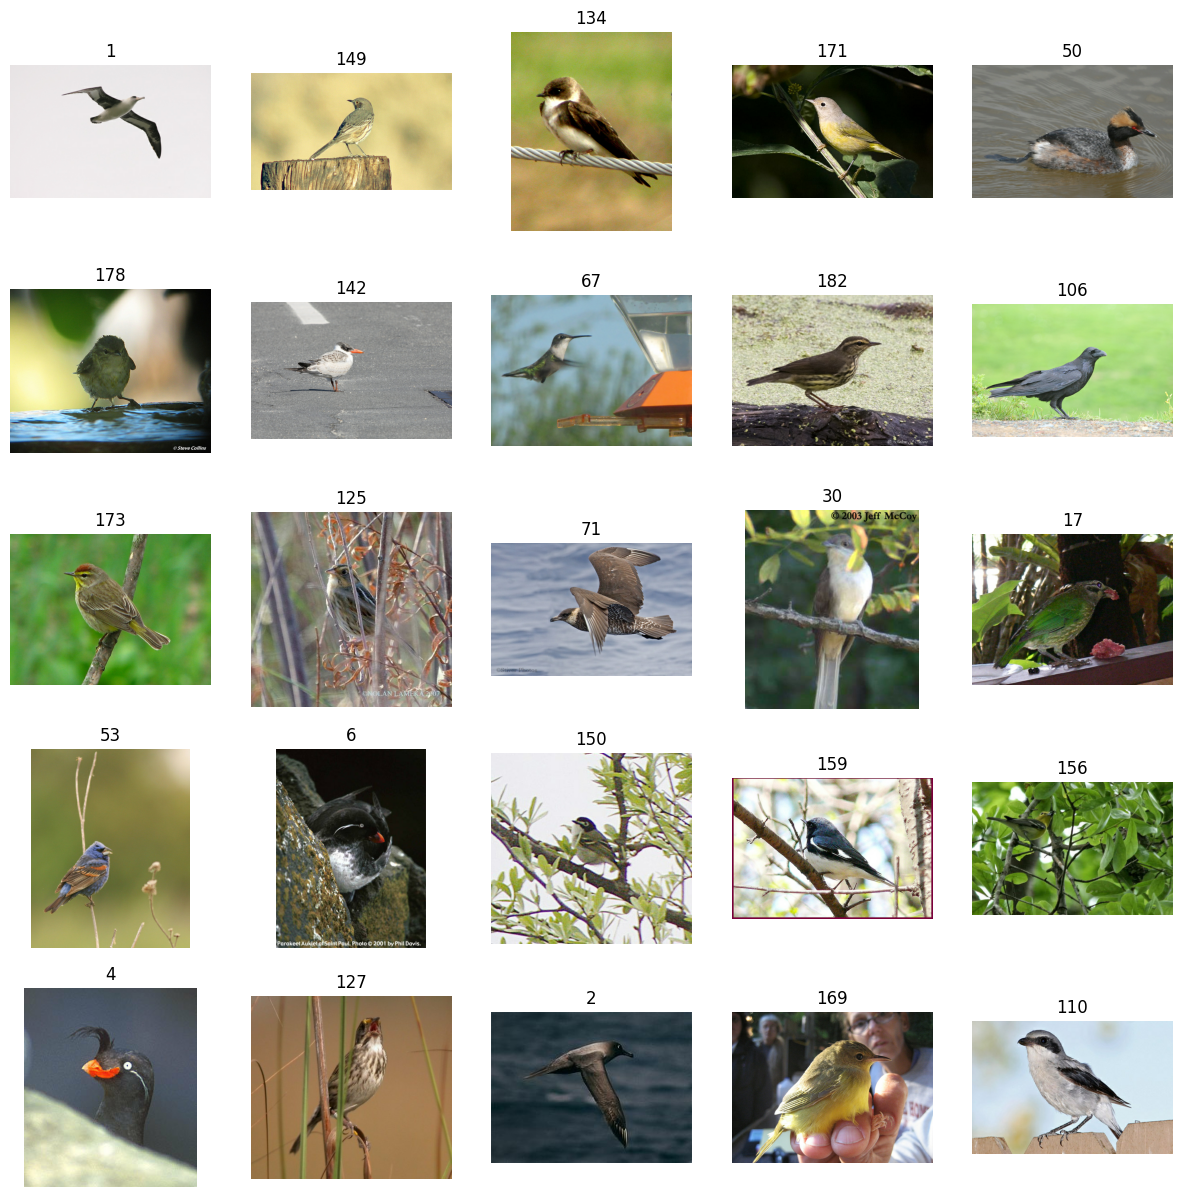

In [12]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
i = 0
rows, cols = 5, 5
num_images_to_show = rows * cols
for image, label in tfds.as_numpy(ds[0]):
    if i < num_images_to_show:
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        ax.set_title(f"{label}")
        plt.axis("off")
        i += 1

In [13]:
max_samples_per_class = 30
label_set = list(range(50))
train_images, train_labels = vit_image_preprocessing(ds[0], label_set, max_samples_per_class)
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (1500, 3, 224, 224)
labels shape = (1500,)


In [14]:
test_images, test_labels = vit_image_preprocessing(ds[1], label_set, max_samples_per_class)
print(f"images shape = {test_images.shape}")
print(f"labels shape = {test_labels.shape}")

images shape = (1389, 3, 224, 224)
labels shape = (1389,)


### Extract features

In [16]:
preprocess = identity_model(input_shape=train_images.shape[1:])
vit_fe = vit_feature_extractor(vit_model=base_model, input_shape=train_images.shape[1:])

In [17]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=vit_fe)
X_test  = extract_features(ds=test_ds, preprocessing_model=preprocess, feature_extractor=vit_fe)
print(f"X_train shape = {X_train.shape}")
print(f"X_test shape = {X_test.shape}")

X_train shape = (1500, 768)
X_test shape = (1389, 768)


In [19]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
else:
    y_train = train_labels
if tf.is_tensor(test_labels):
    y_test = test_labels.numpy()
else:
    y_test = test_labels
print(f"labels = {np.unique(y_train)}")


labels = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [20]:
# unify the train and test
X = np.concatenate((X_train,X_test), axis=0)
y = np.concatenate((y_train,y_test))
print(f"X shape = {X.shape}")
print(f"y shape = {y.shape}")

X shape = (2889, 768)
y shape = (2889,)


In [27]:
num_classes_for_tuning = 5
label_set_for_tuning = list(np.random.choice(a=np.unique(y), size=num_classes_for_tuning, replace=False))
mask = np.in1d(y, label_set_for_tuning)
X_for_tuning = X[mask]
y_for_tuning = y[mask]
X_for_exp = X[~mask]
y_for_exp = y[~mask]
print(f"X_for_tuning shape = {X_for_tuning.shape}")
print(f"y_for_tuning shape = {y_for_tuning.shape}")
print(f"X_for_exp shape = {X_for_exp.shape}")
print(f"y_for_exp shape = {y_for_exp.shape}")

X_for_tuning shape = (296, 768)
y_for_tuning shape = (296,)
X_for_exp shape = (2593, 768)
y_for_exp shape = (2593,)


### Scan train sizes

In [26]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']), #
                        'degree' : hp.choice('degree',list(range(1,10)))}
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
best_params = classifiers_hyper_tune(classifiers=[SVC,LogisticRegression],
                                     search_spaces=[svm_search_space,lasso_search_space],
                                     X=X_for_tuning,
                                     y=y_for_tuning)
svm_best_params = best_params[0]
lasso_best_params = best_params[1]

100%|██████████| 100/100 [00:02<00:00, 36.98trial/s, best loss: -1.0]


In [35]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
num_classes = [10]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
num_experiments = 10
scan_arrays = {'train_sizes':train_sizes, 'num_classes':num_classes}
accuracies, num_features = scan_experiment(classifiers=classifiers,
                                           classifiers_names=bar_labels,
                                           scan_arrays=scan_arrays,
                                           X=X_for_exp,
                                           y=y_for_exp,
                                           num_experiments=num_experiments)





Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.91, std error is 0.02
classifier cs_fs_dp, mean accuracy is 0.91, std error is 0.02
classifier cs_fs_ova, mean accuracy is 0.91, std error is 0.02
classifier svm, mean accuracy is 0.92, std error is 0.01
classifier lasso, mean accuracy is 0.89, std error is 0.02



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num features is 667.0, std error is 17.0
classifier cs_fs_ova, mean num features is 733.0, std error is 2.0
classifier svm, mean num features is 768.0, std error is 0.0
classifier lasso, mean num features is 768.0, std error is 0.0



Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 

#### Display accuracies

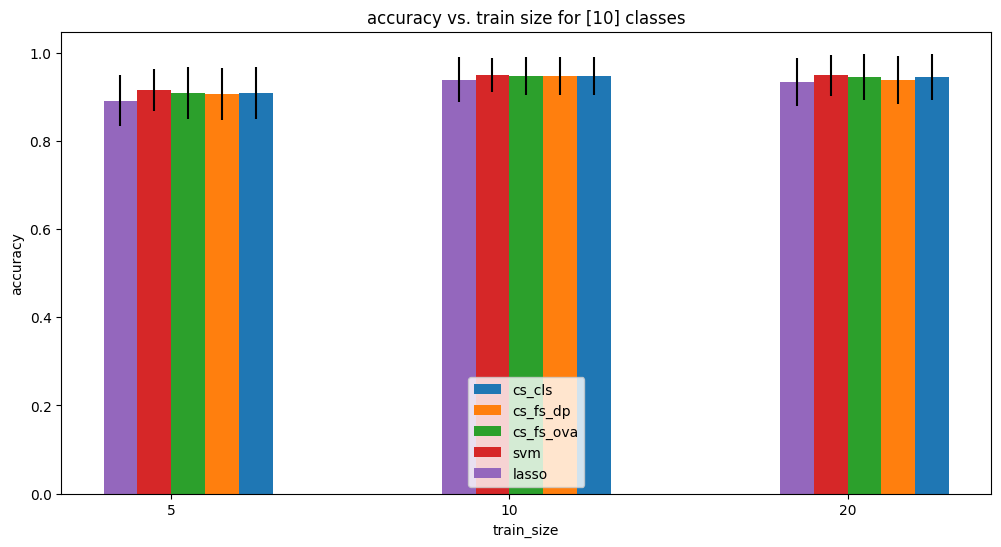

In [36]:
# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes',
                err=np.std(accuracies,axis=2))


#### Display numbers of selected features

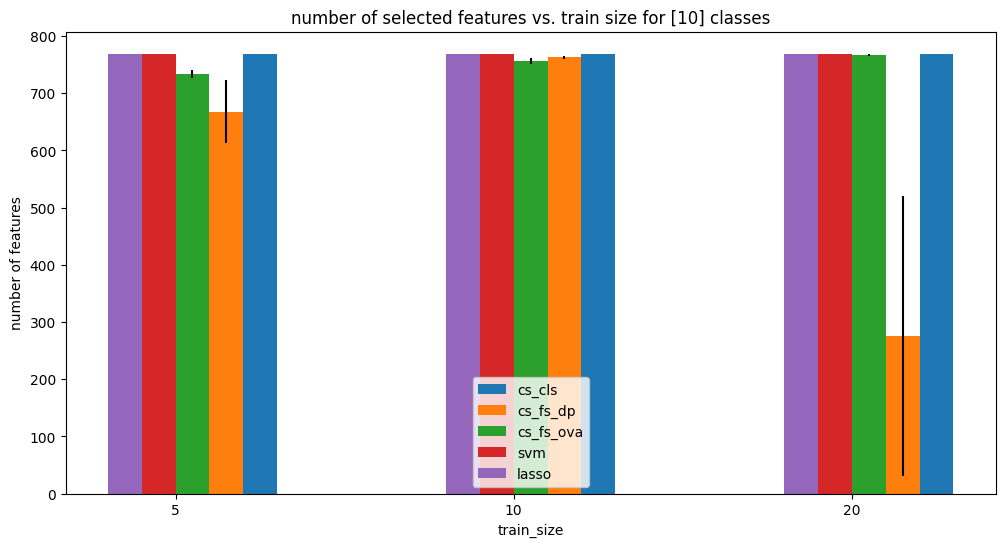

In [37]:
# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes',
                err=np.std(num_features,axis=2))


## Experiment 2 - deep weeds

In [38]:
ds_name = 'deep_weeds'
ds, ds_info = tfds.load(ds_name, split=['train'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(ds_info)

tfds.core.DatasetInfo(
    name='deep_weeds',
    full_name='deep_weeds/3.0.0',
    description="""
    The DeepWeeds dataset consists of 17,509 images capturing eight different weed species native to Australia in situ with neighbouring flora.The selected weed species are local to pastoral grasslands across the state of Queensland.The images were collected from weed infestations at the following sites across Queensland: "Black River", "Charters Towers",  "Cluden", "Douglas", "Hervey Range", "Kelso", "McKinlay" and "Paluma".
    """,
    homepage='https://github.com/AlexOlsen/DeepWeeds',
    data_path='c:/datasets/deep_weeds\\3.0.0',
    file_format=tfrecord,
    download_size=469.32 MiB,
    dataset_size=469.99 MiB,
    features=FeaturesDict({
        'image': Image(shape=(256, 256, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=9),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num

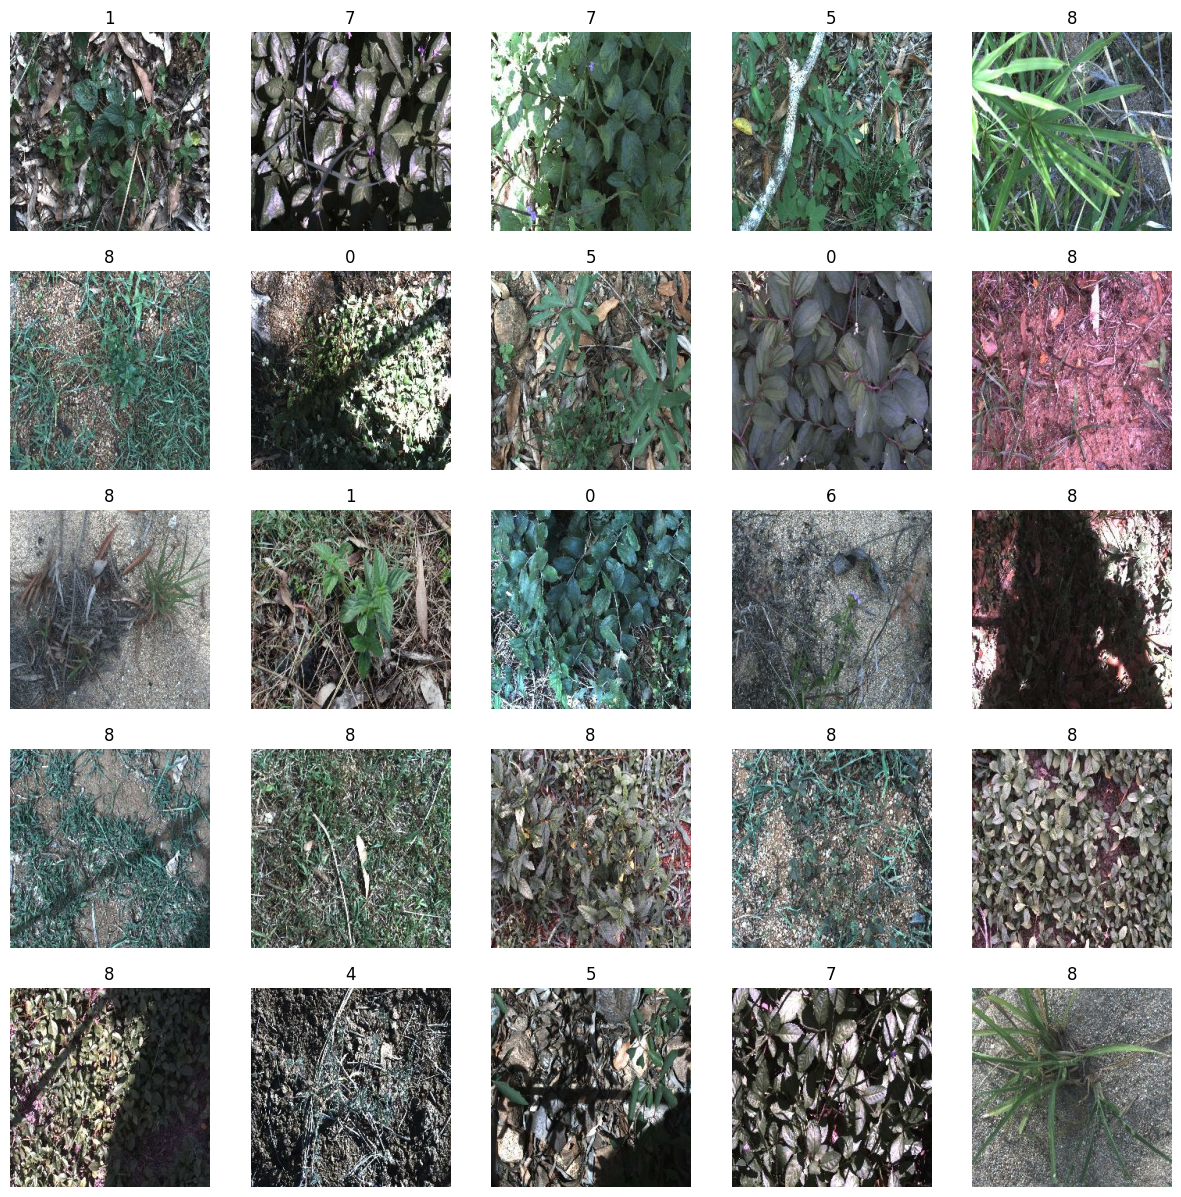

In [40]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
i = 0
rows, cols = 5, 5
num_images_to_show = rows * cols
for image, label in tfds.as_numpy(ds[0]):
    if i < num_images_to_show:
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        ax.set_title(f"{label}")
        plt.axis("off")
        i += 1

In [42]:
max_samples_per_class = 100
label_set = list(range(10))
train_images, train_labels = vit_image_preprocessing(ds[0], label_set, max_samples_per_class)
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (900, 3, 224, 224)
labels shape = (900,)


In [43]:
preprocess = identity_model(input_shape=train_images.shape[1:])
vit_fe = vit_feature_extractor(vit_model=base_model, input_shape=train_images.shape[1:])

In [46]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)

X = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=vit_fe)
print(f"X shape = {X.shape}")

X shape = (900, 768)


In [47]:
if tf.is_tensor(train_labels):
    y = train_labels.numpy()
else:
    y = train_labels
print(f"labels = {np.unique(y)}")

labels = [0 1 2 3 4 5 6 7 8]


In [49]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
num_classes = [5]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
#svm_cls = SVC(**svm_best_params)
#lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova']
num_experiments = 10
scan_arrays = {'train_sizes':train_sizes, 'num_classes':num_classes}
accuracies, num_features = scan_experiment(classifiers=classifiers,
                                           classifiers_names=bar_labels,
                                           scan_arrays=scan_arrays,
                                           X=X,
                                           y=y,
                                           num_experiments=num_experiments)





Measuring accuracy with 5 classes,  5 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.7, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.69, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.7, std error is 0.01



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num features is 153.0, std error is 0.0
classifier cs_fs_ova, mean num features is 486.0, std error is 7.0



Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.76, std error is 0.02
classifier cs_fs_dp, mean accuracy is 0.76, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.76, std error is 0.01



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num

## Experiment 3 - Cassava

In [51]:
ds_name = 'cassava'
ds, ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling c:\datasets\cassava\0.1.0.incompleteS0Y36T\cassava-train.tfrecord*...:   0%|          | 0/5656 [00:0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling c:\datasets\cassava\0.1.0.incompleteS0Y36T\cassava-test.tfrecord*...:   0%|          | 0/1885 [00:00…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling c:\datasets\cassava\0.1.0.incompleteS0Y36T\cassava-validation.tfrecord*...:   0%|          | 0/1889 …

Dataset cassava downloaded and prepared to c:/datasets/cassava\0.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cassava',
    full_name='cassava/0.1.0',
    description="""
    Cassava consists of leaf images for the cassava plant depicting healthy and
    four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
    Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
    Dataset consists of a total of 9430 labelled images.
    The 9430 labelled images are split into a training set (5656), a test set(1885)
    and a validation set (1889). The number of images per class are unbalanced with
    the two disease classes CMD and CBSD having 72% of the images.
    """,
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    data_path='c:/datasets/cassava\\0.1.0',
    file_format=tfrecord,
    download_size=1.26 GiB,
    dataset_size=1.26 GiB,
    features=FeaturesDict({
        'image': Image(shape=(No

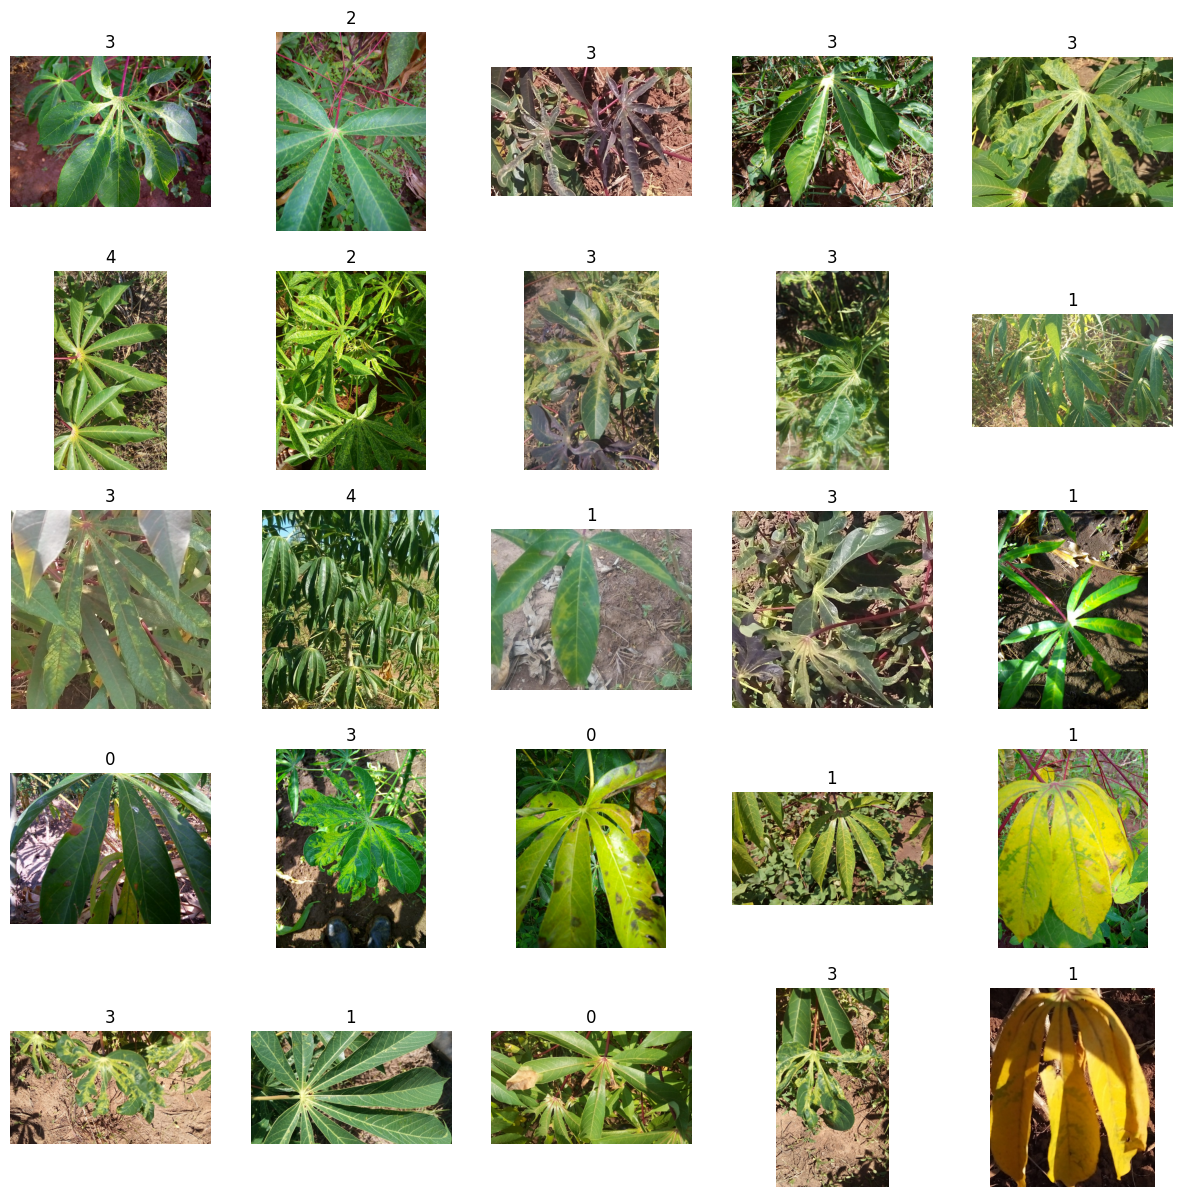

In [52]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
i = 0
rows, cols = 5, 5
num_images_to_show = rows * cols
for image, label in tfds.as_numpy(ds[0]):
    if i < num_images_to_show:
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        ax.set_title(f"{label}")
        plt.axis("off")
        i += 1

In [53]:
max_samples_per_class = 100
label_set = list(range(10))
train_images, train_labels = vit_image_preprocessing(ds[0], label_set, max_samples_per_class)
test_images, test_labels = vit_image_preprocessing(ds[1], label_set, max_samples_per_class)
print(f"train images shape = {train_images.shape}")
print(f"train labels shape = {train_labels.shape}")
print(f"test images shape = {test_images.shape}")
print(f"test labels shape = {test_labels.shape}")

train images shape = (500, 3, 224, 224)
train labels shape = (500,)
test images shape = (500, 3, 224, 224)
test labels shape = (500,)


In [54]:
preprocess = identity_model(input_shape=train_images.shape[1:])
vit_fe = vit_feature_extractor(vit_model=base_model, input_shape=train_images.shape[1:])

In [55]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=vit_fe)
X_test = extract_features(ds=test_ds, preprocessing_model=preprocess, feature_extractor=vit_fe)
print(f"X_train shape = {X_train.shape}")
print(f"X_test shape = {X_test.shape}")

X_train shape = (500, 768)
X_test shape = (500, 768)


In [57]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
    y_test = test_labels.numpy()
else:
    y_train = train_labels
    y_test = test_labels
print(f"labels = {np.unique(y_train)}")

labels = [0 1 2 3 4]


In [59]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
num_classes = [5]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
#svm_cls = SVC(**svm_best_params)
#lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova']
num_experiments = 50
scan_arrays = {'train_sizes':train_sizes, 'num_classes':num_classes}
accuracies, num_features = scan_experiment(classifiers=classifiers,
                                           classifiers_names=bar_labels,
                                           scan_arrays=scan_arrays,
                                           X=X_train,
                                           y=y_train,
                                           num_experiments=num_experiments)





Measuring accuracy with 5 classes,  5 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.4, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.39, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.39, std error is 0.01



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num features is 140.0, std error is 4.0
classifier cs_fs_ova, mean num features is 382.0, std error is 9.0



Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.46, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.46, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.46, std error is 0.01



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean nu

## Experiment 4 - Eurosat

In [9]:
ds_name = 'eurosat'
ds, ds_info = tfds.load(ds_name, split=['train'], shuffle_files=False, with_info=True, as_supervised=True)
print(ds_info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='C:\\Users\\rgolan\\tensorflow_datasets\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }

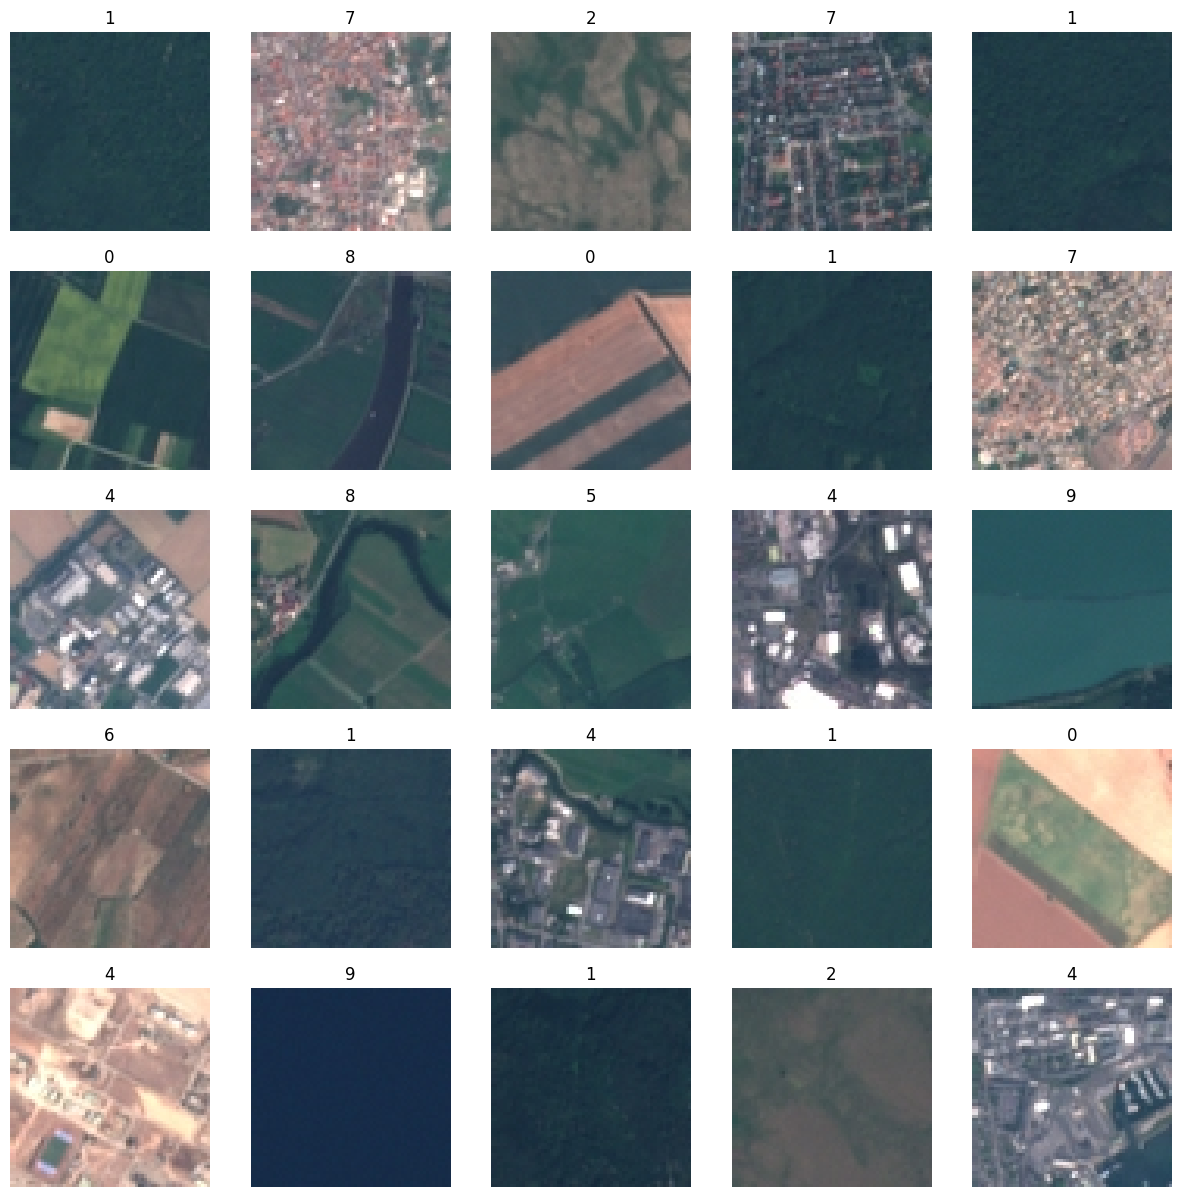

In [10]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
i = 0
rows, cols = 5, 5
num_images_to_show = rows * cols
for image, label in tfds.as_numpy(ds[0]):
    if i < num_images_to_show:
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        ax.set_title(f"{label}")
        plt.axis("off")
        i += 1

In [11]:
max_samples_per_class = 150
label_set = list(range(50))
train_images, train_labels = vit_image_preprocessing(ds[0], label_set, max_samples_per_class)
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (1500, 3, 224, 224)
labels shape = (1500,)


In [12]:
preprocess = identity_model(input_shape=train_images.shape[1:])
vit_fe = vit_feature_extractor(vit_model=base_model, input_shape=train_images.shape[1:])

In [ ]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)

X = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=vit_fe)
print(f"X shape = {X.shape}")

In [ ]:
if tf.is_tensor(train_labels):
    y = train_labels.numpy()
else:
    y = train_labels
print(f"labels = {np.unique(y)}")

In [49]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10,20]
num_classes = [5]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
#svm_cls = SVC(**svm_best_params)
#lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova']
num_experiments = 50
scan_arrays = {'train_sizes':train_sizes, 'num_classes':num_classes}
accuracies, num_features = scan_experiment(classifiers=classifiers,
                                           classifiers_names=bar_labels,
                                           scan_arrays=scan_arrays,
                                           X=X,
                                           y=y,
                                           num_experiments=num_experiments)





Measuring accuracy with 5 classes,  5 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.7, std error is 0.01
classifier cs_fs_dp, mean accuracy is 0.69, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.7, std error is 0.01



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num features is 153.0, std error is 0.0
classifier cs_fs_ova, mean num features is 486.0, std error is 7.0



Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.76, std error is 0.02
classifier cs_fs_dp, mean accuracy is 0.76, std error is 0.01
classifier cs_fs_ova, mean accuracy is 0.76, std error is 0.01



classifier cs_cls, mean num features is 768.0, std error is 0.0
classifier cs_fs_dp, mean num